In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
from google.colab import drive
drive.mount('/content/drive/')
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV,KFold,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab minipro 4 /Permodelan data Home Credit Indonesia/Data HCI/application_train.csv')
print('Jumlah data:', train.shape)
print('Jumlah Missing value :',(train.isnull().sum()/len(train)*100))
print('Jumlah Data Duplikat :',train['SK_ID_CURR'].duplicated().sum())
# Total data yang dimiliki 307.511 baris dan 122 feature termasuk target
# Berdasarkan hasil tidak terdapat data duplikat pada data SK_ID_CURR ini
# menunjukan data perbaris mewakili 1 user. Terdapat banyak data missing, dengan
# begitu saya akan melakukan beberapa metode untuk menghandle data missing

Jumlah data: (307511, 122)
Jumlah Missing value : SK_ID_CURR                       0.000000
TARGET                           0.000000
NAME_CONTRACT_TYPE               0.000000
CODE_GENDER                      0.000000
FLAG_OWN_CAR                     0.000000
FLAG_OWN_REALTY                  0.000000
CNT_CHILDREN                     0.000000
AMT_INCOME_TOTAL                 0.000000
AMT_CREDIT                       0.000000
AMT_ANNUITY                      0.003902
AMT_GOODS_PRICE                  0.090403
NAME_TYPE_SUITE                  0.420148
NAME_INCOME_TYPE                 0.000000
NAME_EDUCATION_TYPE              0.000000
NAME_FAMILY_STATUS               0.000000
NAME_HOUSING_TYPE                0.000000
REGION_POPULATION_RELATIVE       0.000000
DAYS_BIRTH                       0.000000
DAYS_EMPLOYED                    0.000000
DAYS_REGISTRATION                0.000000
DAYS_ID_PUBLISH                  0.000000
OWN_CAR_AGE                     65.990810
FLAG_MOBIL                

## Feature Enginering

In [ ]:
# @title Handle Missing Value
# Saya akan melakukan fillna dengan menggunakan nilai median data feature itu
# sendiri untuk mengurangi nilai Outlier dari pengunakan mean. Dan saya akan
# menggunakan modus untuk feature kaegorikal dan value tertentu tergantung pada
# kondisi feature itu sendiri
train['AMT_ANNUITY'] = train['AMT_ANNUITY'].fillna(train['AMT_ANNUITY'].median())
train['AMT_GOODS_PRICE'] = train['AMT_GOODS_PRICE'].fillna(train['AMT_GOODS_PRICE'].median())
train['NAME_TYPE_SUITE'] = train['NAME_TYPE_SUITE'].fillna(train['NAME_TYPE_SUITE'].mode()[0])
train['OWN_CAR_AGE'] = train['OWN_CAR_AGE'].fillna(0)
train['OCCUPATION_TYPE'] = train['OCCUPATION_TYPE'].fillna('None') # * lakukan Pengelompokan untuk mengurangi dimensi ketika dilakukan label encoding
train['EXT_SOURCE_1'] = train['EXT_SOURCE_1'].fillna(0)
train['EXT_SOURCE_2'] = train['EXT_SOURCE_2'].fillna(0)
train['EXT_SOURCE_3'] = train['EXT_SOURCE_3'].fillna(0)
train['OBS_30_CNT_SOCIAL_CIRCLE'] = train['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0)
train['DEF_30_CNT_SOCIAL_CIRCLE'] = train['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0)
train['OBS_60_CNT_SOCIAL_CIRCLE'] = train['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0)
train['DEF_60_CNT_SOCIAL_CIRCLE'] = train['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)
train['DAYS_LAST_PHONE_CHANGE'] = train['DAYS_LAST_PHONE_CHANGE'].fillna(train['DAYS_LAST_PHONE_CHANGE'].median())
train['AMT_REQ_CREDIT_BUREAU_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(train['AMT_REQ_CREDIT_BUREAU_YEAR'].median())
train['AMT_REQ_CREDIT_BUREAU_HOUR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(train['AMT_REQ_CREDIT_BUREAU_HOUR'].median())
train['AMT_REQ_CREDIT_BUREAU_DAY'] = train['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(train['AMT_REQ_CREDIT_BUREAU_DAY'].median())
train['AMT_REQ_CREDIT_BUREAU_WEEK'] = train['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(train['AMT_REQ_CREDIT_BUREAU_WEEK'].median())
train['AMT_REQ_CREDIT_BUREAU_MON'] = train['AMT_REQ_CREDIT_BUREAU_MON'].fillna(train['AMT_REQ_CREDIT_BUREAU_MON'].median())
train['AMT_REQ_CREDIT_BUREAU_QRT'] = train['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(train['AMT_REQ_CREDIT_BUREAU_QRT'].median())
train['CNT_FAM_MEMBERS'] = train['CNT_FAM_MEMBERS'].fillna(train['CNT_FAM_MEMBERS'].median())
train = train[train['CODE_GENDER'] != 'XNA']

In [ ]:
# @title Label Encoder and Data Cleaning
# Membuat feature baru untuk mempermudah saat akan dilakukan label encoding,
# mengurangi bias dari efek labeling.
train['GROUPING_OCCUPATION_TYPE'] = train['OCCUPATION_TYPE'].replace({'Managers':'High Skill', 'High skill tech staff':'High Skill' ,
                                                                      'Accountants':'High Skill' ,'Medicine staff':'High Skill' ,'IT staff':'High Skill',
                                                                      'Core staff':'Middle Skill' ,'Sales staff':'Middle Skill','Security staff':'Middle Skill',
                                                                      'Cooking staff':'Middle Skill','Private service staff':'Middle Skill',
                                                                      'Realty agents':'Middle Skill','HR staff':'Middle Skill','Laborers':'Low Skill',
                                                                      'Drivers':'Low Skill','Cleaning staff':'Low Skill','Low-skill Laborers':'Low Skill',
                                                                      'Waiters/barmen staff':'Low Skill','Secretaries':'Low Skill','None':'None'})
train['GROUP_OCCUPATION_TYPE'] =train['GROUPING_OCCUPATION_TYPE'] .replace({'None':0,'Low Skill':1,'Middle Skill':2,'High Skill':3}).astype(int)
train['TOTAL_EXT_SOURCES'] = train['EXT_SOURCE_1'] + train['EXT_SOURCE_2'] + train['EXT_SOURCE_3']

# menghapus feature yang memiliki missing value diatas 15 % dan feature yang
# tidak diperlukan
col_drop =['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
            'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG',
            'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE',
            'COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE',
            'LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI',
            'YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI',
            'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE','HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE',
            'EMERGENCYSTATE_MODE']
train.drop(columns=col_drop, inplace=True)


In [ ]:
# cross cek feature yang memiliki value hanya 1
satu_value = [col for col in train.columns if train[col].nunique()==1]
print(satu_value)

[]


In [ ]:
# memeriksa data yang memiliki value yang salah berdasarkan target
employ = train[train['DAYS_EMPLOYED']==365243]
employ['TARGET'].value_counts()

TARGET
0    52384
1     2990
Name: count, dtype: int64

In [ ]:
# dikarenakan pada feature days_employed terdapat value 365243 yang jika kita
# ubah dalam hitungan tau merupakan 1000 tahun lebih. Hal ini tidaklah masuk akal
# karena dalam rekor dunia durasi paling lama seseorang bekerja adalah 80 tahun,
# rata-rata kisaran diindonesia durasi paling lama orang bekerja hanya 30-40
# tahun. Oleh sebab itu maka saya akan mengambil nilai median antara 30 sampai
# 40 tahun yaitu 35 tahun untuk mengganti kesalahan inputan.
# Dan berdasarkan analisa Feature target dapat dilihat bahwa lebih banyak yang
# Current dengan feature DAY_EMPLOYED yang memiliki inputan 365243, ini
# bisa jadi indikator untuk menunjukan bahwa orang yang memiliki durasi kerja
# paling lama merupakan client yang memiliki sistem keuangan yang baik.
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace(365243.0, -12775)
cols = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION']
tahun_2018 = pd.to_datetime('2018-12-31')

for col in cols:
  train[col] = tahun_2018 + pd.to_timedelta(train[col], unit='d')

train['AGE'] = ((tahun_2018 - train['DAYS_BIRTH']).dt.days/365).round(0)
train['REGISTRATION_TIME'] = ((tahun_2018 - train['DAYS_REGISTRATION']).dt.days/365).round(0)
train['DURATION_WORK'] = ((tahun_2018 - train['DAYS_EMPLOYED']).dt.days/365).round(0)

train.drop(columns=cols, inplace= True)

In [ ]:
# Cross cek feature age, registration dam work duration apakah terdapat
# nilai desimal dibelakang koma bukan bernilai 0
def check_values(df, columns):
  result={}
  for col in columns:
    result[col] = df[(df[col]>1) % 1 !=0][col].tolist()
  return result

columns_to_check = ['AGE', 'REGISTRATION_TIME', 'DURATION_WORK']
result = check_values(train, columns_to_check)

# Mengubah type data
train['AGE']=  train['AGE'].astype(int)
train['REGISTRATION_TIME']= train['REGISTRATION_TIME'].astype(int)
train['DURATION_WORK']= train['DURATION_WORK'].astype(int)

# Print the result
print('AGE:', result['AGE'])
print('REGISTRATION TIME:', result['REGISTRATION_TIME'])
print('WORK_DURATION:', result['DURATION_WORK'])

AGE: []
REGISTRATION TIME: []
WORK_DURATION: []


In [ ]:
# Memperbaiki value yang salah dan melakukan Mapping (Labeling Manual)
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace({'N':0,'Y':1}).astype(int)
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace({'N':0,'Y':1}).astype(int)
train['WEEKDAY_APPR_PROCESS_START'] = train['WEEKDAY_APPR_PROCESS_START'].replace({'SUNDAY':0,'MONDAY':1,'TUESDAY':2, 'WEDNESDAY':3,'THURSDAY':4,'FRIDAY':5,'SATURDAY':6}).astype(int)
train['EDUCATION'] = train['NAME_EDUCATION_TYPE'].replace({'Lower secondary': 0, 'Secondary / secondary special': 1, 'Incomplete higher': 3, 'Higher education': 2, 'Academic degree':4}).astype(int)
train['MARITAL_sTATUS'] = train['NAME_FAMILY_STATUS'].replace({'Married':'Married','Civil marriage':'Married','Single / not married':'Single','Separated':'Separated','Widow':'Separated', 'Unknown':'Unknown'})
train['MARITAL_STATUS'] = train['MARITAL_sTATUS'].replace({'Married':1,'Single':0,'Separated':2,'Unknown':3}).astype(int)
train.drop(columns=['MARITAL_sTATUS','GROUPING_OCCUPATION_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS'], inplace=True)

In [ ]:
# @title Label Encoder
# melakukan Label Encoder
col = ['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE']
Label = LabelEncoder()
train[col] = train[col].apply(Label.fit_transform)

In [ ]:
# @title OneHot Encoder
# melakukan OneHot Encoder
ohe = OneHotEncoder()
col = ['NAME_CONTRACT_TYPE','CODE_GENDER']
encod = ohe.fit_transform(train[col]).toarray()
encod_df = pd.DataFrame(encod, columns=ohe.get_feature_names_out(col))
train.drop(columns=col, inplace=True)
train = pd.concat([train, encod_df], axis=1)
train.dropna(inplace=True)

In [ ]:
# terdapat sekitar 20 feature berisi kepemilikan dokument tertentu dalam
# value binner. Saya akan melakukan penggabungan ke 20 feature tersebut tanpa
# menghilangkan insight yaitu menggunakan PCA, agar mengurangi noise dari
# banyaknya feature
cols =['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
pca = PCA(n_components=1)
pca_resul =pca.fit_transform(train[cols])
pca_result = pd.DataFrame(pca_resul ,columns=['PCA_DOCUMENT'])
trainn = pd.concat([train,pca_result],axis=1)
trainn.drop(columns=cols, inplace=True)

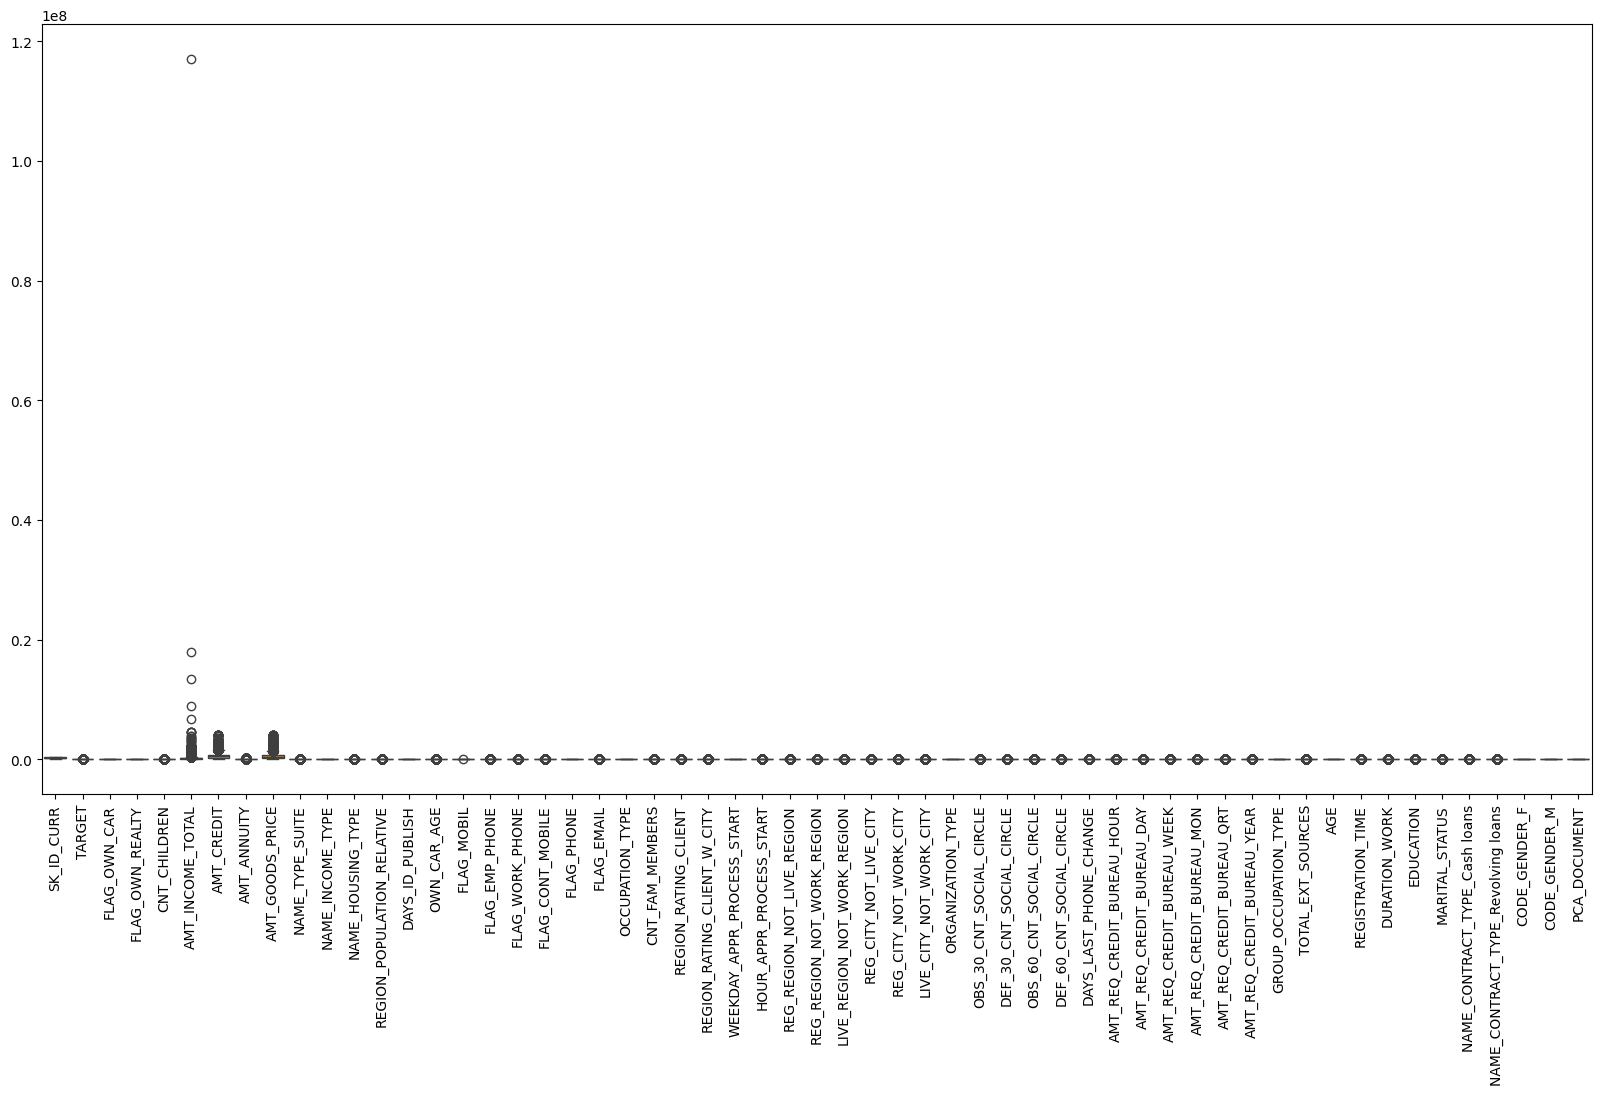

In [ ]:
# @title Cross Cek Outlier

plt.figure(figsize=(20,10))
sns.boxplot(trainn)
plt.xticks(rotation=90)
plt.show()

# Setelah dilakukan Data Engginering masih terdapat 3 feature yang memiliki
# nilai outlier. Feature tersebut adalah AMT_INCOME_TOTAL, AMT_CREDIT
# dan AMT_GOOD_PRICE, namun dalam kasus yang saya handle saat ini,
# Dataset yang saya miliki adalah dataset keuangan yang menurut saya sangat
# memungkinkan jika ketiga feature tersebut memiliki nilai outlier.
# Karena feature ini menggambarkan Keuangan (Ekonomi) dari setiap individu.
# Karena setiap individu memiliki tingkat keuangan berbeda. Namun dalam proses
# permodelan saat ini, saya akan menggunakan Algoritma Logistik Regression,
# Algoritma ini sangat sensitive terhadap data yang memiliki outlier dan
# memiliki sifat Multikolinieritas. Maka dari itu saya akan menghandle nilai
# outlier tersebut dengan menggunakan metode IQR yang lebih robust untuk model ini,
# dan untuk menghandle sifat Multikolinearitas saya akan menghandle dengan
# Metode Rekursif Feature Elimination (RFE dari model Logistik tersebut).

In [ ]:
# @title Handle Outlier Data
def remove_outlier(data, feature):
  df_outlier = trainn.copy()
  for feature in feature:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_outlier = df_outlier[(df_outlier[feature] >= lower_bound) & (df_outlier[feature] <= upper_bound)]
    return df_outlier

feature_clean = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE']
df_outlier = remove_outlier(trainn, feature_clean)
df_outlier.shape

(293468, 57)

In [ ]:
# @title Standarisasi
scale =StandardScaler()
a_train = df_outlier.drop(columns=['SK_ID_CURR','TARGET'])
b_train = df_outlier['TARGET']
df_scale =pd.DataFrame(scale.fit_transform(a_train), columns=a_train.columns)
df_scaler = pd.concat([df_scale, b_train], axis=1)
df_scaler.sample(5)

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,GROUP_OCCUPATION_TYPE,TOTAL_EXT_SOURCES,AGE,REGISTRATION_TIME,DURATION_WORK,EDUCATION,MARITAL_STATUS,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,PCA_DOCUMENT,TARGET
15736,-0.699943,0.664754,-0.575067,-0.933586,-1.133547,-0.895753,-1.096235,0.440614,-0.680832,-0.306556,-0.820089,-1.196426,-0.450224,0.001846,-2.099086,-0.500646,0.041104,1.606092,-0.238143,0.619710,-1.262435,-0.136029,-0.096587,-0.091084,-0.931852,-0.11859,-0.220815,-0.196086,-0.291261,-0.54843,-0.468179,1.332674,-0.593630,-0.322783,-0.591784,-0.277892,0.610007,-0.071043,-0.058899,-0.155427,-0.268475,-0.396141,-0.441205,-1.171058,0.057399,1.412546,-0.592862,1.859569,1.312099,2.001479,0.324351,-0.324351,0.718410,-0.718410,-0.629679,0.0
173188,-0.699943,0.664754,0.813512,-0.300924,0.942911,0.318422,0.441249,0.440614,0.903395,-0.306556,0.827654,1.268267,-0.450224,0.001846,0.476398,-0.500646,0.041104,-0.622629,-0.238143,0.619710,-0.162909,-0.136029,-0.096587,-0.659254,-1.854274,-0.11859,-0.220815,-0.196086,-0.291261,-0.54843,-0.468179,0.159745,0.650083,1.903717,0.663037,2.465762,-0.090005,-0.071043,-0.058899,-0.155427,-0.268475,-0.396141,1.259922,-1.171058,0.025786,-1.740098,-1.109699,-0.702298,-0.520189,-1.883192,0.324351,-0.324351,0.718410,-0.718410,-0.629679,0.0
140801,-0.699943,0.664754,0.813512,-0.884379,0.072161,-0.161078,0.249064,0.440614,0.903395,-0.306556,1.166558,-1.732200,-0.450224,0.001846,0.476398,1.997418,0.041104,-0.622629,-0.238143,-0.304097,0.936617,-0.136029,-0.096587,1.613428,0.912991,-0.11859,-0.220815,-0.196086,-0.291261,-0.54843,-0.468179,-0.671080,1.893796,-0.322783,1.917858,-0.277892,-1.291065,-0.071043,-0.058899,-0.155427,-0.268475,4.807667,-0.441205,-0.231425,0.972122,-0.578598,-1.006332,-0.382065,-0.520189,0.059143,0.324351,-0.324351,0.718410,-0.718410,-0.629679,0.0
102779,1.428688,-1.504316,-0.575067,1.807950,0.521744,0.208103,0.505311,-0.121564,0.903395,-0.306556,-0.123677,-0.759452,-0.119077,0.001846,0.476398,-0.500646,0.041104,-0.622629,-0.238143,-2.151712,-0.162909,-0.136029,-0.096587,1.045258,-0.316904,-0.11859,-0.220815,-0.196086,-0.291261,-0.54843,-0.468179,-1.208673,-0.593630,-0.322783,-0.591784,-0.277892,1.159583,-0.071043,-0.058899,-0.155427,-0.268475,-0.396141,-1.008248,1.647841,0.972905,1.246617,-0.902964,-0.862415,-0.520189,0.059143,0.324351,-0.324351,0.718410,-0.718410,-0.629679,0.0
161277,-0.699943,0.664754,-0.575067,0.261442,1.765676,2.026850,1.722486,0.440614,-0.680832,-0.306556,1.166558,-0.799237,-0.450224,0.001846,-2.099086,-0.500646,0.041104,-0.622629,-0.238143,0.619710,-0.162909,-0.136029,-0.096587,1.045258,-0.931852,-0.11859,-0.220815,-0.196086,-0.291261,-0.54843,-0.468179,1.332674,-0.593630,-0.322783,-0.591784,-0.277892,-1.042360,-0.071043,-0.058899,-0.155427,-0.268475,-0.396141,0.125837,-1.171058,-1.687019,1.080688,-1.213067,1.859569,-0.520189,0.059143,-3.083081,3.083081,-1.391962,1.391962,1.759831,0.0


In [ ]:
print('Before: ',df_scaler.shape)
df_scaler.dropna(inplace=True)
print('After: ',df_scaler.shape)

Before:  (306881, 56)
After:  (280051, 56)


## Feature Selection

In [ ]:
# @title RECUSIVE FEATURE ELIMINATION (RFE)
# Alasan saya lebih memilih menggunakan metode Recusive Feature Elimination karena dalam
# metode ini secara iteratif menghapus fitur tidak penting, dapat mengatasi masalah
# Multikolinearitas dengan mengurangi redundasi.

X = df_scaler.drop(columns=['TARGET'])
y = df_scaler['TARGET']

logis = LogisticRegression()
rfe = RFE(logis, n_features_to_select = 20)
rfe.fit(X, y)
select_features = X.columns[rfe.support_]

print(rfe.support_)
print('-------------------------------------------')
print('Select Feature:\n', select_features)

[False False  True False  True  True  True False False False False False
  True  True False  True  True  True False  True  True  True  True False
 False False  True  True False False False False  True False  True False
  True False False False False False  True False False False False  True
 False False False False False False False]
-------------------------------------------
Select Feature:
 Index(['CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'DURATION_WORK'],
      dtype='object')


In [ ]:
# Data hasil pemilihan feature
df = df_scaler[['CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE','OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                'FLAG_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS','REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION','OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR','DURATION_WORK','TARGET']]

In [ ]:
# @title Class Imbalance

df['Target'] = df['TARGET'] ==1
df['Target'].value_counts()

X = df[[col for col in df.columns if col not in ['TARGET','Target']]].values
y = df['TARGET']
print(X.shape)
print(y.shape)
print(df_scaler['TARGET'].value_counts())

X_under, y_under = RandomUnderSampler(sampling_strategy=0.5).fit_resample(X,y)
X_over, y_over = RandomOverSampler(sampling_strategy=0.5).fit_resample(X,y)
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X,y)

(280051, 20)
(280051,)
TARGET
0.0    257133
1.0     22918
Name: count, dtype: int64


Confusion MatriX:
 [[45836     0]
 [22918     0]]


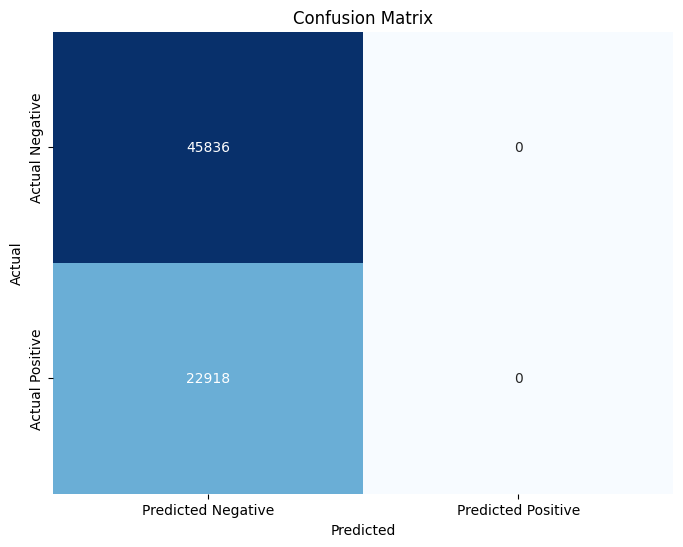

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      1.00      0.80     45836
         1.0       0.00      0.00      0.00     22918

    accuracy                           0.67     68754
   macro avg       0.33      0.50      0.40     68754
weighted avg       0.44      0.67      0.53     68754



In [ ]:
# @title  Logistric Regresion data UnderSampling
# Saya akan melakukan perbandingan hasil modeling dengan menggunakan dataset
# yang sudah dilakukan handle class imblance, untuk model yang pertama saya akan
# menggunakan data yang sudah diundersampling sebelumnya

#Melakukan Pemisahan Fitur dan Target
X_train = X_under # data train berasal dari hasil seleksi feature dengan RFE
y_train = y_under


# Disini saya melakukan training keseluruh data Train dengan menggunakan
# metode K-Fold Cross Validation .
logis = LogisticRegression(C=1.0, solver='liblinear', max_iter=50, random_state=42)
logis.fit(X_train,y_train)

# ----------------------------------------------------------------------------------------------------------------
# Saya akan mencoba untuk melihat hasil confusion matrik untuk data training
# dengan menggunakan metode validasi silang
y_pred = cross_val_predict(logis, X_train, y_train, cv=5)

# Menghitung Confusion Matrik
cm = confusion_matrix(y_train,y_pred)
print('Confusion MatriX:\n',cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Menghitung Classification Report untuk metrik lainnya
cr = classification_report(y_train, y_pred)
print('Classification Report:\n',cr)




ROC AUC Score: 0.5097699761944909


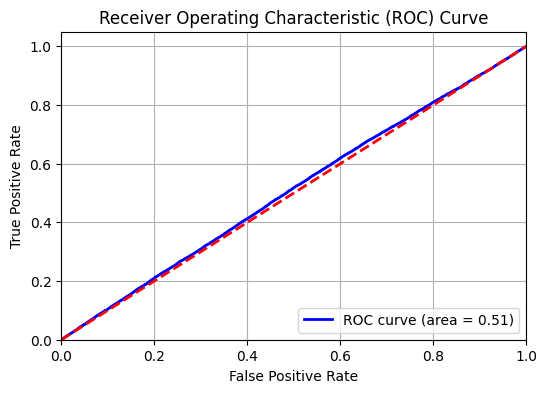

In [ ]:
# @title Menampilkan Kurva ROC (UnderSampling)
# Menghitung probabilitas prediksi untuk kelas positif
y_proba = cross_val_predict(logis, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Menghitung ROC AUC score
roc_auc = roc_auc_score(y_train, y_proba)
print('ROC AUC Score:', roc_auc)

# Menghitung nilai FPR, TPR, dan thresholds
fpr, tpr, thresholds = roc_curve(y_train, y_proba)

# Plotting Kurva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Confusion MatriX:
 [[257132      1]
 [128566      0]]


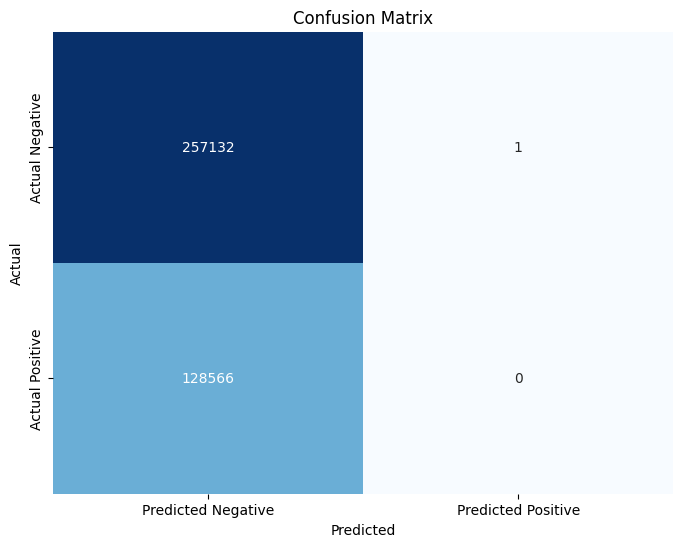

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      1.00      0.80    257133
         1.0       0.00      0.00      0.00    128566

    accuracy                           0.67    385699
   macro avg       0.33      0.50      0.40    385699
weighted avg       0.44      0.67      0.53    385699



In [ ]:
# @title Logistric Regresion data OverSampling
X_train = X_over
y_train = y_over
logis = LogisticRegression(C=1.0, solver='liblinear', max_iter=50, random_state=42)
logis.fit(X_train,y_train)
y_pred = cross_val_predict(logis, X_train, y_train, cv=5)

# Menghitung Confusion Matrik
cm = confusion_matrix(y_train,y_pred)
print('Confusion MatriX:\n',cm)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Menghitung Classification Report untuk metrik lainnya
cr = classification_report(y_train, y_pred)
print('Classification Report:\n',cr)




ROC AUC Score: 0.5116798816727985


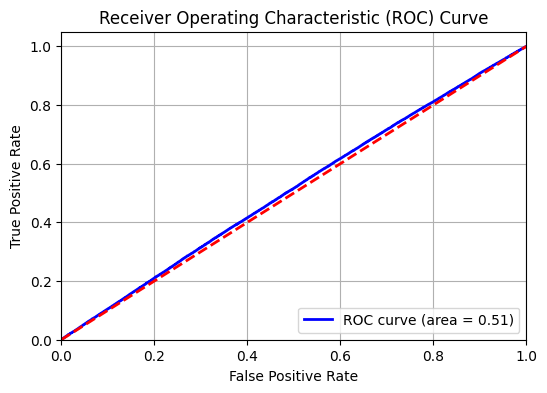

In [ ]:
# @title Menampilkan Kurva ROC (OverSampling)
y_proba = cross_val_predict(logis, X_train, y_train, cv=7, method='predict_proba')[:, 1]

# Menghitung ROC AUC score
roc_auc = roc_auc_score(y_train, y_proba)
print('ROC AUC Score:', roc_auc)

# Menghitung nilai FPR, TPR, dan thresholds
fpr, tpr, thresholds = roc_curve(y_train, y_proba)

# Plotting Kurva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Confusion MatriX:
 [[121598 135535]
 [111349 145784]]


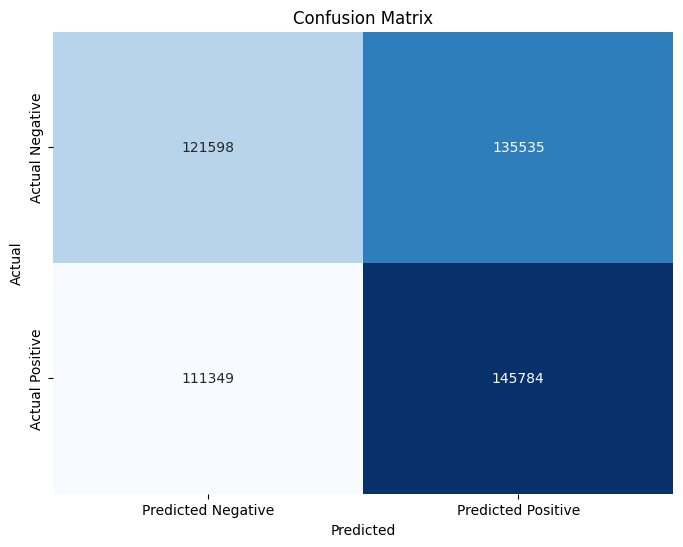

Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.47      0.50    257133
         1.0       0.52      0.57      0.54    257133

    accuracy                           0.52    514266
   macro avg       0.52      0.52      0.52    514266
weighted avg       0.52      0.52      0.52    514266



In [ ]:
# @title Logistric Regresion data SMOTE
# Saya akan melakukan perbandingan hasil modeling dengan menggunakan dataset
# yang sudah dilakukan handle class imblance, untuk model yang pertama saya akan
# menggunakan data yang sudah Smote sebelumnya
X_train = X_smote
y_train = y_smote
logis = LogisticRegression(C=0.01, solver='saga', penalty='l2', max_iter=150, random_state=42)
logis.fit(X_train,y_train)
y_pred = cross_val_predict(logis, X_train, y_train, cv=7)

# Menghitung Confusion Matrik
cm = confusion_matrix(y_train,y_pred)
print('Confusion MatriX:\n',cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Menghitung Classification Report untuk metrik lainnya
cr = classification_report(y_train, y_pred)
print('Classification Report:\n',cr)

ROC AUC Score: 0.5273432167155405


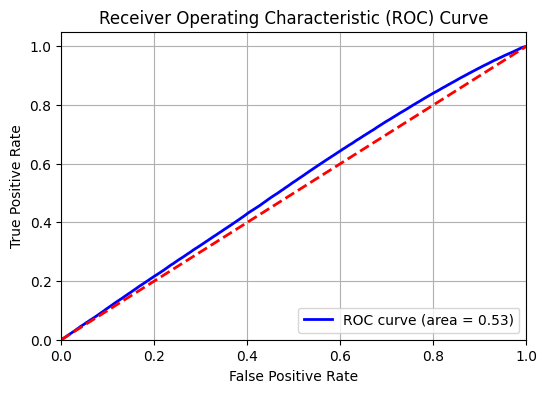

In [ ]:
# @title Menampilkan Kurva ROC

y_proba = cross_val_predict(logis, X_train, y_train, cv=5, method='predict_proba')[:, 1]
roc_auc = roc_auc_score(y_train, y_proba)
print('ROC AUC Score:', roc_auc)
fpr, tpr, thresholds = roc_curve(y_train, y_proba)

# Plotting Kurva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
'''
  Setelah dilakukan perbandingan terhadap ketiga metode Class Imbalance, didapat hasil permodelan dengan metode SMOTE lebih unggul, setelah saya melakukan
  riset kenapa hasilnya demikian. Dikarenakan metode SMOTE menggunakan prinsip kerja dengan cara membuat sample data baru dari kelas minoritas dengan interpolasi
  antara sample yang ada. Dengan begitu dapat mengurangi resiko overfitting dari metode OVERSAMPLING, dengan menambahkan variasi baru pada kelas minoritas
  sehingga menghasilkan sample sintetis baru. Sedangkan penggunaan menggunakan undersampling prinsipnya adalah mengurangi jumlah sample dari kelas mayoritas
  sehingga menurangi ukuruan dataset dan menghilangkan informasi penting dari kelas mayoritas dengan begitu dapat menghilangkan kemampuan untuk mengeneralisasi
  dengan baik. Sedangkan oversampling menambahkan jumlah sampel dari kelas minoritas, hal ini dapat menyebabkan ovrfitting karena menduplikasi sampel yang
  ada tanpa menambahkan informasi baru.
'''

'''
   Dalam permodelan dengan algoritma Logistik Regresiion syarat untuk mendapatkan hasil perfoma model yang lebih baik, dataset yang dimiliki tidak kompleks,
   tidak memiliki outlier, dan tidak memiliki sifat multikolinieritas. Dengan begitu penggunaan algoritma Logistik Regression kurang cocok untuk dataset yang
   saya miliki.
'''